In [1]:
# import packages
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np

from pandas import Series, DataFrame
import Bio
from Bio import SeqIO,AlignIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.mixture import GaussianMixture as GMM

from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# methods

# parseFasta(data) credit to Luke
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])
    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

def get_kmer_table(paths,k_min,k_max):
    genes,gene_len = read_fasta(paths)
    count_vect = CountVectorizer(analyzer='char', ngram_range=(k_min, k_max))
    X = count_vect.fit_transform(genes)
    chars = count_vect.get_feature_names()
    kmers = X.toarray()
    kmer_freq = []
    for i in range(len(genes)):
        kmer_freq.append(kmers[i] / gene_len[i])
    input = pd.DataFrame(kmer_freq, columns=chars)
    return input

def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# genes: a list of gene sequences, which can directly be generated from get_gene_sequences().
def get_gene_len(genes):
    gene_len = []

    for i in range(len(genes)):
        gene_len.append(len(genes[i]))
    return gene_len

def read_fasta(paths):
    all_genes = []
    all_gene_len = []
    
    for path in paths:
        virus = parseFasta(path)
        virus = virus.drop_duplicates(keep="last")
        genes = list(virus['Sequence'])
        genes_seq = get_gene_sequences(path)
        gene_len = get_gene_len(genes_seq)
        all_genes = all_genes + genes_seq
        all_gene_len = all_gene_len + gene_len
    return all_genes,all_gene_len

def get_predictions(paths,k_min,k_max,num_class,cov_type):
    kmer_table = get_kmer_table(paths, k_min, k_max)
    gmm = GMM(n_components=num_class,covariance_type=cov_type).fit(kmer_table)
    labels = gmm.predict(kmer_table)
    return labels



In [109]:
def sammon(x, n, display = 2, maxhalves = 20, maxiter = 500, tolfun = 1e-9):

    import numpy as np 
    from scipy.spatial.distance import cdist

    D = cdist(x, x) # distance matrix
    init = 'pca' # initialization from pca

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    [UU,DD,_] = np.linalg.svd(x)
    y = UU[:,:n]*DD[:n] 
    
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]
    
def sammon_plot(y,plot_labels):
    x_axis = []
    y_axis = []

    for i in range(len(y)):
        x_axis.append(y[i][0])
        y_axis.append(y[i][1])

    sns.scatterplot(x_axis, y_axis, hue=plot_labels, legend='full')
    plt.show()

In [4]:
def cal_accuracy(labels, predictions):
    return 1-sum(abs(labels - predictions))/(len(labels))

def create_labels (files):
    labels = []
    for f in files:
        length = len(get_gene_sequences(f))
    
    return labels

In [5]:
df = get_kmer_table(["datasets/bat_flu.fa","datasets/penguin_flu.fa"],2,3)
df

,aa,aaa,aac,aag,aar,aat,ac,aca,acc,acg,...,tgc,tgg,tgt,tt,tta,ttc,ttg,ttt,yg,ygc
0,0.163382,0.059133,0.024967,0.035042,0.0,0.043802,0.063513,0.030223,0.014017,0.002628,...,0.009636,0.020149,0.010951,0.063951,0.015331,0.011827,0.020587,0.016207,0.0,0.0
1,0.150594,0.057684,0.021576,0.027741,0.0,0.043153,0.058124,0.025099,0.013210,0.003523,...,0.014091,0.018494,0.013650,0.069573,0.020696,0.011449,0.014971,0.022457,0.0,0.0
2,0.164332,0.063025,0.019608,0.035481,0.0,0.045752,0.042484,0.021475,0.008403,0.001867,...,0.007937,0.017274,0.014006,0.075630,0.016340,0.019141,0.017274,0.022876,0.0,0.0
3,0.148280,0.058126,0.028470,0.023132,0.0,0.038553,0.067023,0.032622,0.011862,0.004152,...,0.017200,0.022539,0.013049,0.078885,0.014828,0.015421,0.023725,0.024911,0.0,0.0
4,0.133869,0.048193,0.020750,0.035475,0.0,0.029451,0.046185,0.020750,0.009371,0.002008,...,0.013387,0.025435,0.009371,0.058233,0.006693,0.015395,0.018072,0.018072,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.103371,0.034831,0.016854,0.028090,0.0,0.023596,0.053933,0.017978,0.008989,0.005618,...,0.016854,0.022472,0.012360,0.070787,0.006742,0.019101,0.023596,0.021348,0.0,0.0
171,0.116107,0.034149,0.023335,0.022197,0.0,0.036426,0.056915,0.027319,0.010814,0.005122,...,0.011952,0.022197,0.021628,0.064883,0.009106,0.019920,0.020489,0.015367,0.0,0.0
172,0.111491,0.034173,0.021786,0.029475,0.0,0.026057,0.057668,0.026057,0.011961,0.004699,...,0.012388,0.024776,0.013669,0.055959,0.010679,0.011534,0.017941,0.015805,0.0,0.0
173,0.075949,0.026290,0.018500,0.018500,0.0,0.012658,0.055501,0.016553,0.015579,0.009737,...,0.019474,0.026290,0.011685,0.060370,0.008763,0.010711,0.024343,0.016553,0.0,0.0


In [6]:
df2 = df.drop_duplicates(keep="last")
df2

,aa,aaa,aac,aag,aar,aat,ac,aca,acc,acg,...,tgc,tgg,tgt,tt,tta,ttc,ttg,ttt,yg,ygc
0,0.163382,0.059133,0.024967,0.035042,0.0,0.043802,0.063513,0.030223,0.014017,0.002628,...,0.009636,0.020149,0.010951,0.063951,0.015331,0.011827,0.020587,0.016207,0.0,0.0
1,0.150594,0.057684,0.021576,0.027741,0.0,0.043153,0.058124,0.025099,0.013210,0.003523,...,0.014091,0.018494,0.013650,0.069573,0.020696,0.011449,0.014971,0.022457,0.0,0.0
3,0.148280,0.058126,0.028470,0.023132,0.0,0.038553,0.067023,0.032622,0.011862,0.004152,...,0.017200,0.022539,0.013049,0.078885,0.014828,0.015421,0.023725,0.024911,0.0,0.0
4,0.133869,0.048193,0.020750,0.035475,0.0,0.029451,0.046185,0.020750,0.009371,0.002008,...,0.013387,0.025435,0.009371,0.058233,0.006693,0.015395,0.018072,0.018072,0.0,0.0
5,0.103448,0.029946,0.026316,0.016334,0.0,0.030853,0.072595,0.036298,0.012704,0.003630,...,0.015426,0.023593,0.019964,0.086207,0.017241,0.020871,0.024501,0.023593,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.103371,0.034831,0.016854,0.028090,0.0,0.023596,0.053933,0.017978,0.008989,0.005618,...,0.016854,0.022472,0.012360,0.070787,0.006742,0.019101,0.023596,0.021348,0.0,0.0
171,0.116107,0.034149,0.023335,0.022197,0.0,0.036426,0.056915,0.027319,0.010814,0.005122,...,0.011952,0.022197,0.021628,0.064883,0.009106,0.019920,0.020489,0.015367,0.0,0.0
172,0.111491,0.034173,0.021786,0.029475,0.0,0.026057,0.057668,0.026057,0.011961,0.004699,...,0.012388,0.024776,0.013669,0.055959,0.010679,0.011534,0.017941,0.015805,0.0,0.0
173,0.075949,0.026290,0.018500,0.018500,0.0,0.012658,0.055501,0.016553,0.015579,0.009737,...,0.019474,0.026290,0.011685,0.060370,0.008763,0.010711,0.024343,0.016553,0.0,0.0


In [59]:
def Diff(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_dif

kept_viruses = df2.index.values
all_viruses = df.index.values
dropped_viruses = Diff(list(kept_viruses), list(all_viruses))

In [7]:
bat_len = len(get_gene_sequences("datasets/bat_flu.fa"))
penguin_len = len(get_gene_sequences("datasets/penguin_flu.fa"))
zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*penguin_len, axis=None)

In [28]:
plot_labels = labels1[kept_viruses]
plot_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [111]:
X = df2.as_matrix(columns = df2.columns)
[y, E] = sammon(X,2)

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


epoch = 1 : E = 0.1183423930
epoch = 2 : E = 0.1168283272
epoch = 3 : E = 0.1138299177
epoch = 4 : E = 0.0932908615
epoch = 5 : E = 0.0785206957
epoch = 6 : E = 0.0759335670
epoch = 7 : E = 0.0746315268
epoch = 8 : E = 0.0676048298
epoch = 9 : E = 0.0660193190
epoch = 10 : E = 0.0649323269
epoch = 11 : E = 0.0600209367
epoch = 12 : E = 0.0559691925
epoch = 13 : E = 0.0461838268
epoch = 14 : E = 0.0350060310
epoch = 15 : E = 0.0339631008
epoch = 16 : E = 0.0314987013
epoch = 17 : E = 0.0313420483
epoch = 18 : E = 0.0271701865
epoch = 19 : E = 0.0270742136
epoch = 20 : E = 0.0270694311
epoch = 21 : E = 0.0269587611
epoch = 22 : E = 0.0269403509
epoch = 23 : E = 0.0269000265
epoch = 24 : E = 0.0252992661
epoch = 25 : E = 0.0252858048
epoch = 26 : E = 0.0252377061
epoch = 27 : E = 0.0251927367
epoch = 28 : E = 0.0248854138
epoch = 29 : E = 0.0248787183
epoch = 30 : E = 0.0243679611
epoch = 31 : E = 0.0243598242
epoch = 32 : E = 0.0243167318
epoch = 33 : E = 0.0243031587
epoch = 34 : E = 0.

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


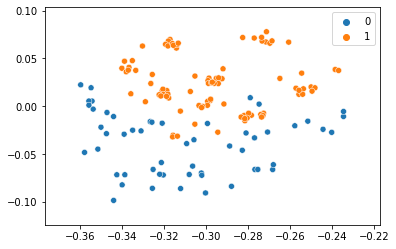

In [114]:
sammon_plot(y,plot_labels)

In [116]:
def PCA_plot(x,y,n_dim):
    
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=n_dim)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, pd.Series(labels1)], axis = 1)
    finalDf.columns = ['principal component 1', 'principal component 2','target']
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0,1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color)
    ax.legend(targets)
    plt.show()

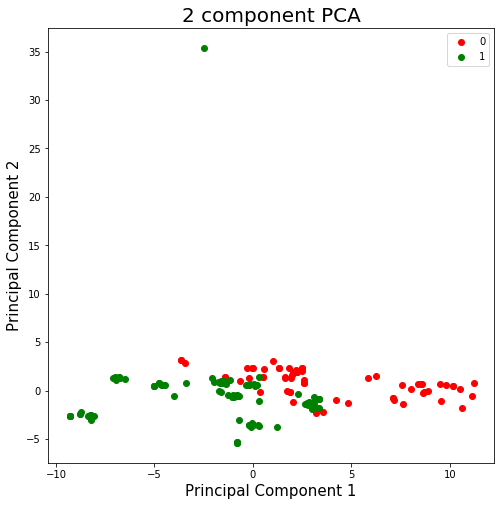

In [117]:
# PCA:

PCA_plot(df,labels1,2)

In [118]:
# x: sample features
# y: labels
def tsne_plot(x,y):
    tsne = TSNE()
    X_embedded = tsne.fit_transform(x)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


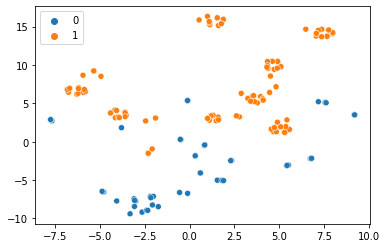

In [120]:
tsne_plot(df,labels1)

In [45]:
# change the following parameters to user inputs
paths = ["datasets/bat_flu.fa","datasets/penguin_flu.fa"]
k_min = 2
k_max = 3
num_class = 2
cov_type = 'full'
predictions1_1 = get_predictions(paths,k_min,k_max,num_class,cov_type)

In [46]:
predictions1_1

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [47]:
labels1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [48]:
accuracy1_1 = 1 - sum(abs(labels1 - predictions1_1))/(bat_len+penguin_len)
accuracy1_1

0.8514285714285714

In [49]:
prediction_labels = predictions1_1[kept_viruses]
prediction_labels

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

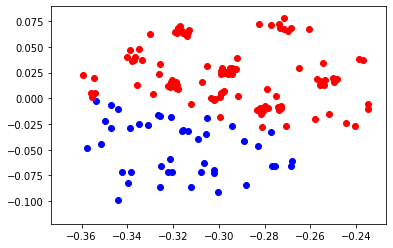

In [58]:
sammon_plot(y,prediction_labels,2)

In [60]:
k_min = 4
k_max = 5
num_class = 2
cov_type = 'full'
predictions1_2 = get_predictions(paths,k_min,k_max,num_class,cov_type)

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


epoch = 1 : E = 0.2323939684
epoch = 2 : E = 0.2288647548
epoch = 3 : E = 0.2250787391
epoch = 4 : E = 0.1902715685
epoch = 5 : E = 0.1683472439
epoch = 6 : E = 0.1454737429
epoch = 7 : E = 0.1433070371
epoch = 8 : E = 0.1392142396
epoch = 9 : E = 0.1365588827
epoch = 10 : E = 0.1182822138
epoch = 11 : E = 0.1149158555
epoch = 12 : E = 0.1121567183
epoch = 13 : E = 0.1118915406
epoch = 14 : E = 0.1112941204
epoch = 15 : E = 0.1110799049
epoch = 16 : E = 0.1038570127
epoch = 17 : E = 0.0990887205
epoch = 18 : E = 0.0989779899
epoch = 19 : E = 0.0751285668
epoch = 20 : E = 0.0736235057
epoch = 21 : E = 0.0705262483
epoch = 22 : E = 0.0605240276
epoch = 23 : E = 0.0604929197
epoch = 24 : E = 0.0564104599
epoch = 25 : E = 0.0554341446
epoch = 26 : E = 0.0546765263
epoch = 27 : E = 0.0537508254
epoch = 28 : E = 0.0537458064
epoch = 29 : E = 0.0536531085
epoch = 30 : E = 0.0535518338
epoch = 31 : E = 0.0533127691
epoch = 32 : E = 0.0532835762
epoch = 33 : E = 0.0530219694
epoch = 34 : E = 0.

epoch = 315 : E = 0.0513477939
epoch = 316 : E = 0.0513477927
epoch = 317 : E = 0.0513477925
epoch = 318 : E = 0.0513477909
epoch = 319 : E = 0.0513477899
epoch = 320 : E = 0.0513477897
epoch = 321 : E = 0.0513477884
epoch = 322 : E = 0.0513477875
epoch = 323 : E = 0.0513477874
epoch = 324 : E = 0.0513477862
epoch = 325 : E = 0.0513477855
epoch = 326 : E = 0.0513477854
epoch = 327 : E = 0.0513477844
epoch = 328 : E = 0.0513477838
epoch = 329 : E = 0.0513477837
epoch = 330 : E = 0.0513477829
epoch = 331 : E = 0.0513477824
epoch = 332 : E = 0.0513477823
epoch = 333 : E = 0.0513477816
epoch = 334 : E = 0.0513477812
epoch = 335 : E = 0.0513477811
epoch = 336 : E = 0.0513477805
epoch = 337 : E = 0.0513477802
epoch = 338 : E = 0.0513477801
epoch = 339 : E = 0.0513477796
epoch = 340 : E = 0.0513477793
TolFun exceeded: Optimisation terminated


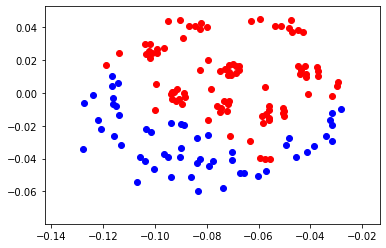

In [61]:
df3 = get_kmer_table(["datasets/bat_flu.fa","datasets/penguin_flu.fa"],4,5)
df3 = df3.drop_duplicates(keep="last")
kept_index = df3.index.values
X = df3.as_matrix(columns = df3.columns)
[y, E] = sammon(X,2)
sammon_plot(y,labels1[kept_index],2)

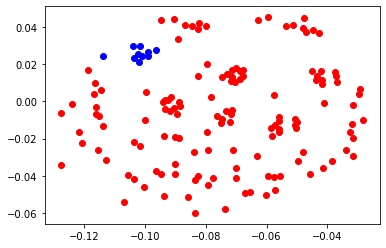

In [62]:
sammon_plot(y,predictions1_2[kept_index],2)

In [63]:
accuracy1_2 = 1 - sum(abs(labels1 - predictions1_2))/(bat_len+penguin_len)
accuracy1_2

0.56

In [43]:
k_min = 2
k_max = 5
num_class = 2
cov_type = 'full'
predictions1_3 = get_predictions(paths,k_min,k_max,num_class,cov_type)

In [45]:
accuracy1_3 = 1 - sum(abs(labels1 - predictions1_3))/(bat_len+penguin_len)
accuracy1_3

0.6799999999999999

In [50]:
k_min = 2
k_max = 3
num_class = 2
cov_type = 'diag'
predictions1_4 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy1_4 = 1 - sum(abs(labels1 - predictions1_4))/(bat_len+penguin_len)
accuracy1_4

0.8457142857142858

In [51]:
k_min = 2
k_max = 3
num_class = 2
cov_type = 'tied'
predictions1_5 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy1_5 = 1 - sum(abs(labels1 - predictions1_5))/(bat_len+penguin_len)
accuracy1_5

0.6628571428571428

In [52]:
k_min = 2
k_max = 3
num_class = 2
cov_type = 'spherical'
predictions1_6 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy1_6 = 1 - sum(abs(labels1 - predictions1_6))/(bat_len+penguin_len)
accuracy1_6

0.8228571428571428

In [65]:
cat_len = len(get_gene_sequences("datasets/cat_flu.fa"))
labels2 = np.append(labels1, [2]*cat_len, axis=None)

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


epoch = 1 : E = 0.1458892109
epoch = 2 : E = 0.1345174989
epoch = 3 : E = 0.1328193552
epoch = 4 : E = 0.1313376228
epoch = 5 : E = 0.1198872942
epoch = 6 : E = 0.1188823270
epoch = 7 : E = 0.1120442992
epoch = 8 : E = 0.1052837398
epoch = 9 : E = 0.1026053426
epoch = 10 : E = 0.0956360657
epoch = 11 : E = 0.0949379154
epoch = 12 : E = 0.0944044981
epoch = 13 : E = 0.0932635222
epoch = 14 : E = 0.0932333673
epoch = 15 : E = 0.0899346809
epoch = 16 : E = 0.0861886152
epoch = 17 : E = 0.0830916782
epoch = 18 : E = 0.0813475754
epoch = 19 : E = 0.0568274163
epoch = 20 : E = 0.0567143272
epoch = 21 : E = 0.0503968657
epoch = 22 : E = 0.0387055191
epoch = 23 : E = 0.0377330338
epoch = 24 : E = 0.0376173797
epoch = 25 : E = 0.0369687176
epoch = 26 : E = 0.0349895104
epoch = 27 : E = 0.0300001321
epoch = 28 : E = 0.0292909292
epoch = 29 : E = 0.0292864137
epoch = 30 : E = 0.0284961593
epoch = 31 : E = 0.0275449688
epoch = 32 : E = 0.0270548791
epoch = 33 : E = 0.0268622686
epoch = 34 : E = 0.

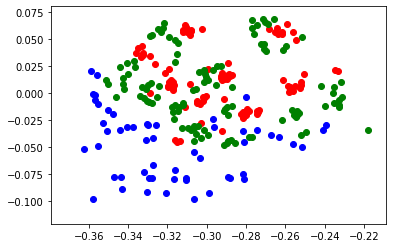

In [68]:
df4 = get_kmer_table(["datasets/bat_flu.fa","datasets/penguin_flu.fa","datasets/cat_flu.fa"],2,3)
df4 = df4.drop_duplicates(keep="last")
kept_viruses= df4.index.values
plot_labels2 = labels2[kept_viruses]
X = df4.as_matrix(columns = df4.columns)
[y, E] = sammon(X,2)
sammon_plot(y,plot_labels2,3)

In [53]:
paths = ["datasets/bat_flu.fa","datasets/penguin_flu.fa","datasets/cat_flu.fa"]
k_min = 2
k_max = 3
num_class = 3
cov_type = 'full'
predictions2_1 = get_predictions(paths,k_min,k_max,num_class,cov_type)

In [54]:
predictions2_1

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2,
       2, 2, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 0, 2,
       0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 0,
       2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2,
       0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2,
       1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0,
       2, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 2,
       0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 1, 2, 2,
       2, 2, 0, 2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 2, 2,
       0, 0, 1])

In [66]:
def accuracy(labels,predictions):
    err = 0
    for i in range(len(labels)):
        if (labels[i] != predictions[i]):
            err += 1
    return (1-err/len(labels))

accuracy2_1 = accuracy(labels2,predictions2_1)
accuracy2_1

0.4290657439446367

In [68]:
k_min = 2
k_max = 5
num_class = 3
cov_type = 'full'
predictions2_3 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy2_3 = accuracy(labels2,predictions2_3)
accuracy2_3

0.24221453287197237

In [69]:
k_min = 2
k_max = 3
num_class = 3
cov_type = 'diag'
predictions2_4 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy2_4 = accuracy(labels2,predictions2_4)
accuracy2_4

0.3044982698961938

In [77]:
k_min = 2
k_max = 3
num_class = 3
cov_type = 'tied'
predictions2_5 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy2_5 = accuracy(labels2,predictions2_5)
accuracy2_5

0.4117647058823529

In [80]:
k_min = 2
k_max = 3
num_class = 3
cov_type = 'spherical'
predictions2_6 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy2_6 = accuracy(labels2,predictions2_6)
accuracy2_6

0.46366782006920415

In [73]:
paths = ["datasets/Dengue.fa","datasets/mers.fa"]
k_min = 2
k_max = 3
num_class = 2
cov_type = 'full'
predictions3_1 = get_predictions(paths,k_min,k_max,num_class,cov_type)

In [71]:
den_len = len(get_gene_sequences("datasets/Dengue.fa"))
mers_len = len(get_gene_sequences("datasets/mers.fa"))
zeros = np.zeros(den_len)
labels3 = np.append(zeros, [1]*mers_len,axis=None)

In [88]:
accuracy3_1 = 1-sum(abs(labels3 - predictions3_1))/(den_len+mers_len)
accuracy3_1

0.9725986148750376

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


epoch = 1 : E = 0.0794376224
epoch = 2 : E = 0.0793062377
epoch = 3 : E = 0.0765091864
epoch = 4 : E = 0.0718596819
epoch = 5 : E = 0.0698740013
epoch = 6 : E = 0.0690453159
epoch = 7 : E = 0.0689320254
epoch = 8 : E = 0.0688293936
epoch = 9 : E = 0.0684055601
epoch = 10 : E = 0.0681489992
epoch = 11 : E = 0.0637992799
epoch = 12 : E = 0.0627211486
epoch = 13 : E = 0.0620516272
epoch = 14 : E = 0.0555645596
epoch = 15 : E = 0.0553263334
epoch = 16 : E = 0.0552637066
epoch = 17 : E = 0.0550331198
epoch = 18 : E = 0.0504218491
epoch = 19 : E = 0.0502125429
epoch = 20 : E = 0.0496915809
epoch = 21 : E = 0.0486178202
epoch = 22 : E = 0.0485897495
epoch = 23 : E = 0.0485109420
epoch = 24 : E = 0.0482395159
epoch = 25 : E = 0.0474071180
epoch = 26 : E = 0.0472908134
epoch = 27 : E = 0.0452835815
epoch = 28 : E = 0.0448809420
epoch = 29 : E = 0.0445741100
epoch = 30 : E = 0.0440975096
epoch = 31 : E = 0.0422584793
epoch = 32 : E = 0.0420630693
epoch = 33 : E = 0.0414043094
epoch = 34 : E = 0.

epoch = 269 : E = 0.0076276160
epoch = 270 : E = 0.0076276157
epoch = 271 : E = 0.0076276154
epoch = 272 : E = 0.0076276152
epoch = 273 : E = 0.0076276150
epoch = 274 : E = 0.0076276148
epoch = 275 : E = 0.0076276147
epoch = 276 : E = 0.0076276145
epoch = 277 : E = 0.0076276143
epoch = 278 : E = 0.0076276141
epoch = 279 : E = 0.0076276140
epoch = 280 : E = 0.0076276139
epoch = 281 : E = 0.0076276138
epoch = 282 : E = 0.0076276136
epoch = 283 : E = 0.0076276135
epoch = 284 : E = 0.0076276133
epoch = 285 : E = 0.0076276132
epoch = 286 : E = 0.0076276132
epoch = 287 : E = 0.0076276130
epoch = 288 : E = 0.0076276129
epoch = 289 : E = 0.0076276128
epoch = 290 : E = 0.0076276127
epoch = 291 : E = 0.0076276126
epoch = 292 : E = 0.0076276126
epoch = 293 : E = 0.0076276125
epoch = 294 : E = 0.0076276124
epoch = 295 : E = 0.0076276123
epoch = 296 : E = 0.0076276123
epoch = 297 : E = 0.0076276122
TolFun exceeded: Optimisation terminated


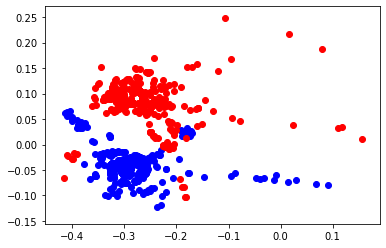

In [72]:
df5 = get_kmer_table(["datasets/Dengue.fa","datasets/mers.fa"],2,3)
df5 = df5.drop_duplicates(keep="last")
kept_index = df5.index.values
X = df5.as_matrix(columns = df5.columns)
[y, E] = sammon(X,2)
sammon_plot(y,labels3[kept_index],2)

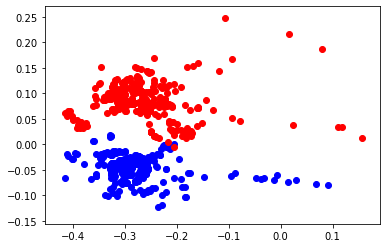

In [74]:
sammon_plot(y,predictions3_1[kept_index],2)

In [91]:
k_min = 3
k_max = 3
num_class = 2
cov_type = 'full'
predictions3_2 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy3_2 = 1-sum(abs(labels3 - predictions3_2))/(den_len+mers_len)
accuracy3_2

0.020174646190906365

In [92]:
k_min = 4
k_max = 4
num_class = 2
cov_type = 'full'
predictions3_3 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy3_3 = 1-sum(abs(labels3 - predictions3_3))/(den_len+mers_len)
accuracy3_3

0.014152363745859708

In [93]:
k_min = 2
k_max = 3
num_class = 2
cov_type = 'diag'
predictions3_4 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy3_4 = 1-sum(abs(labels3 - predictions3_4))/(den_len+mers_len)
accuracy3_4

0.04727491719361643

In [96]:
k_min = 2
k_max = 3
num_class = 2
cov_type = 'tied'
predictions3_5 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy3_5 = 1-sum(abs(labels3 - predictions3_5))/(den_len+mers_len)
accuracy3_5

0.028906955736224038

In [97]:
k_min = 2
k_max = 3
num_class = 2
cov_type = 'spherical'
predictions3_6 = get_predictions(paths,k_min,k_max,num_class,cov_type)
accuracy3_6 = 1-sum(abs(labels3 - predictions3_6))/(den_len+mers_len)
accuracy3_6

0.9698885877747666

In [83]:
accu1 = [accuracy1_1,accuracy1_2,accuracy1_3,accuracy1_4,accuracy1_5,accuracy1_6]
accu1

[0.8571428571428572,
 0.49142857142857144,
 0.6799999999999999,
 0.8457142857142858,
 0.6628571428571428,
 0.8228571428571428]

In [84]:
accu2 = [accuracy2_1,accuracy2_2,accuracy2_3,accuracy2_4,accuracy2_5,accuracy2_6]
accu2

[0.4290657439446367,
 0.32179930795847755,
 0.24221453287197237,
 0.4982698961937716,
 0.4117647058823529,
 0.46366782006920415]

In [98]:
accu3 = [accuracy3_1,1-accuracy3_2,1-accuracy3_3,1-accuracy3_4,1-accuracy3_5,accuracy3_6]
accu3

[0.9725986148750376,
 0.9798253538090936,
 0.9858476362541403,
 0.9527250828063836,
 0.971093044263776,
 0.9698885877747666]

In [111]:
df = pd.DataFrame(data=[accu1,accu2,accu3], index=['Flu from bat or penguin (175 seqs)','Flu from bat or penguin or cat (289 seqs)','Dengue or Mers (3321 seqs)'])
df.rename(columns={0:'2-3mer with full covariance',
                   1:'4-5mer with full covariance',
                   2:'2-5mer with full covariance',
                   3:'2-3mer with diag covariance',
                   4: '2-3mer with tied covariance',
                   5:'2-3mer with spherical covariance'}, 
                 inplace=True)

In [112]:
df

,2-3mer with full covariance,4-5mer with full covariance,2-5mer with full covariance,2-3mer with diag covariance,2-3mer with tied covariance,2-3mer with spherical covariance
Flu from bat or penguin (175 seqs),0.857143,0.491429,0.680000,0.845714,0.662857,0.822857
Flu from bat or penguin or cat (289 seqs),0.429066,0.321799,0.242215,0.498270,0.411765,0.463668
Dengue or Mers (3321 seqs),0.972599,0.979825,0.985848,0.952725,0.971093,0.969889


In [107]:
len(labels3)

3321

In [108]:
len(labels2)

289

In [110]:
len(labels1)

175